# Classificació de vols

In [1]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns

# Exercici 1

Classifica els diferents vols utilitzant l'algorisme de K-means.

### Data

In [2]:
# Load the dataframe
url = 'https://www.dropbox.com/s/477prm0zakkxkga/DelayedFlights.csv?dl=1'
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [3]:
df

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936753,7009710,2008,12,13,6,1250.0,1220,1617.0,1552,DL,...,9.0,18.0,0,N,0,3.0,0.0,0.0,0.0,22.0
1936754,7009717,2008,12,13,6,657.0,600,904.0,749,DL,...,15.0,34.0,0,N,0,0.0,57.0,18.0,0.0,0.0
1936755,7009718,2008,12,13,6,1007.0,847,1149.0,1010,DL,...,8.0,32.0,0,N,0,1.0,0.0,19.0,0.0,79.0
1936756,7009726,2008,12,13,6,1251.0,1240,1446.0,1437,DL,...,13.0,13.0,0,N,0,NaN,NaN,NaN,NaN,NaN


Les columnes que conté són:
 - **Unnamed**: índex
 - **Year**: any del vol
 - **Month**: mes del vol
 - **DayofMonth**: dia del vol
 - **DayOfWeek**: dia de la setmana del vol
 - **DepTime**: hora de sortida del vol real
 - **CRSDepTime**: hora de sortida del vol programada
 - **ArrTime**: hora d'arribada del vol real
 - **CRSArrTime**: hora d'arribada del vol programada
 - **UniqueCarrier**: aerolínea
 - **FlightNum**: número de vol
 - **TailNum**: número de cua de l'avió
 - **ActualElapsedTime**: temps de vol real en minuts
 - **CRSElapsedTime**: temps de vol programat en minuts
 - **AirTime**: temps en l'aire en minuts
 - **ArrDelay**: retràs en l'hora d'arribada en minuts
 - **DepDelay**: retràs en l'hora de sortida en minuts
 - **Origin**: aeroport de sortida
 - **Dest**: aeroport de destinació
 - **Distance**: distància del vol
 - **Taxiln**: temps de taxi de l'arribada en minuts
 - **TaxiOut**: temps de taxi de la sortida en minuts
 - **Cancelled**: cancel·lació
 - **CancellationCode**: codi de cancel·lació
 - **Diverted**: desviat
 - **CarrierDelay**: retràs atribuït a l'aerolínea en minuts
 - **WeatherDelay**: retràs atribuït al clima en minuts
 - **NASDelay**: retràs atribuït al sistema d'aviació nacional en minuts
 - **SecurityDelay**: retràs atribuït a la seguretat en minuts
 - **LateAircraftDelay**: retràs atribuït a l'arribada amb retràs d'un avió en minuts

### Feature selection

Since K-means can only work with numerical features, we will focus on those. Moreover, we will remove not informative columns such as `Unnamed: 0` which has a unique value per flight and `Year` which has the same value for every flight.

In [4]:
# Selection of numerical features
features = df.select_dtypes(include=np.number).columns.tolist()

In [5]:
# Study of unique values per column
df[features].nunique()

Unnamed: 0           1936758
Year                       1
Month                     12
DayofMonth                31
DayOfWeek                  7
DepTime                 1438
CRSDepTime              1207
ArrTime                 1440
CRSArrTime              1364
FlightNum               7499
ActualElapsedTime        673
CRSElapsedTime           515
AirTime                  650
ArrDelay                1128
DepDelay                1058
Distance                1419
TaxiIn                   180
TaxiOut                  332
Cancelled                  2
Diverted                   2
CarrierDelay             983
WeatherDelay             599
NASDelay                 574
SecurityDelay            156
LateAircraftDelay        564
dtype: int64

In [6]:
# Remove Unnamed: 0
features.remove('Unnamed: 0')

In [7]:
# Remove Year
features.remove('Year')

### Missing values

Since K-means can't work with null values, we will discard any columns with a great number of them and we will imput those values missing in columns with a few null values. 

In [8]:
# Check null columns
missing_values = df[features].isnull().sum().reset_index()
missing_values.columns = ['column', 'null_count']
missing_values['null_percentage'] = missing_values.null_count / df.shape[0] * 100
missing_values[missing_values.null_count > 0].sort_values('null_percentage', ascending=False)

,column,null_count,null_percentage
18,CarrierDelay,689270,35.588855
19,WeatherDelay,689270,35.588855
20,NASDelay,689270,35.588855
21,SecurityDelay,689270,35.588855
22,LateAircraftDelay,689270,35.588855
8,ActualElapsedTime,8387,0.433043
10,AirTime,8387,0.433043
11,ArrDelay,8387,0.433043
5,ArrTime,7110,0.367108
14,TaxiIn,7110,0.367108


In [9]:
# Remove columns with a high number of null values
[features.remove(col) for col in missing_values[missing_values.null_percentage > 10].column]

[None, None, None, None, None]

In [10]:
# Imput null values
for col in missing_values[(missing_values.null_percentage > 0) & (missing_values.null_percentage <= 10)].column:
    df[col].fillna(df[col].median(), inplace = True)

### Data sets

In [11]:
X = df[features].values

In [12]:
Xsmall = df[features].sample(10000, random_state=0)

### K-means

To find which is the optimal number of clusters, we will use the method of the elbow.

In [13]:
kmeans = []
labels = []
elbow_scores = []
for n_clusters in range(2, 11):
    kmeans.append(KMeans(n_clusters=n_clusters, random_state=0))
    kmeans[-1].fit(X)
    labels.append(kmeans[-1].labels_)
    elbow_scores.append(kmeans[-1].inertia_)

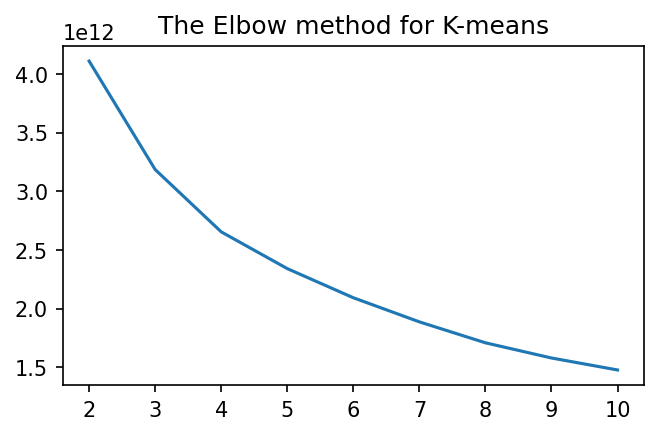

In [14]:
fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.set_title('The Elbow method for K-means')
plt.plot(range(2, 11), elbow_scores);

The optimal number of clusters with the elbow methods is 4.

### Feature importance

We can see that the most important features are FlightNum, CRSArrTime, ArrTime, DepTime and CRSDepTime

In [15]:
pd.DataFrame(kmeans[2].cluster_centers_, columns=features).T.sort_values(0, ascending=False)

,0,1,2,3
FlightNum,3244.627350,888.016330,5828.010821,857.751969
CRSArrTime,1619.376208,1971.950841,1573.257631,1222.133162
ArrTime,1614.848553,1907.208712,1583.410744,1217.264693
DepTime,1520.020216,1812.824740,1488.357069,1132.909065
CRSDepTime,1459.726349,1740.401221,1416.916450,1131.341909
Distance,542.040804,862.512845,449.285094,1021.726357
CRSElapsedTime,106.558145,147.055969,98.713916,162.900354
ActualElapsedTime,105.657735,145.615383,99.523148,161.081749
AirTime,82.096757,119.905853,72.845027,136.601523
DepDelay,43.027809,44.157199,50.013446,37.999422


### Visualization of clusters

To visualize the clusters of the K-means we can take advantage of the PCA that allow us to project the data into a lower dimensional space. From the original 19-dimensions we can reduce it to a 2-dimensional space and plot the clusters there.

In [16]:
# PCA
pca = PCA(n_components=2, random_state=0)

# Get principal components
pc = pca.fit_transform(X)
pc = pd.DataFrame(data = pc, columns = ['PC1', 'PC2'])

# Add clusters
pc['kmeans4'] = labels[2]

In [17]:
# Get cluster centers
clusters = kmeans[2].cluster_centers_
clusters = pca.transform(clusters)

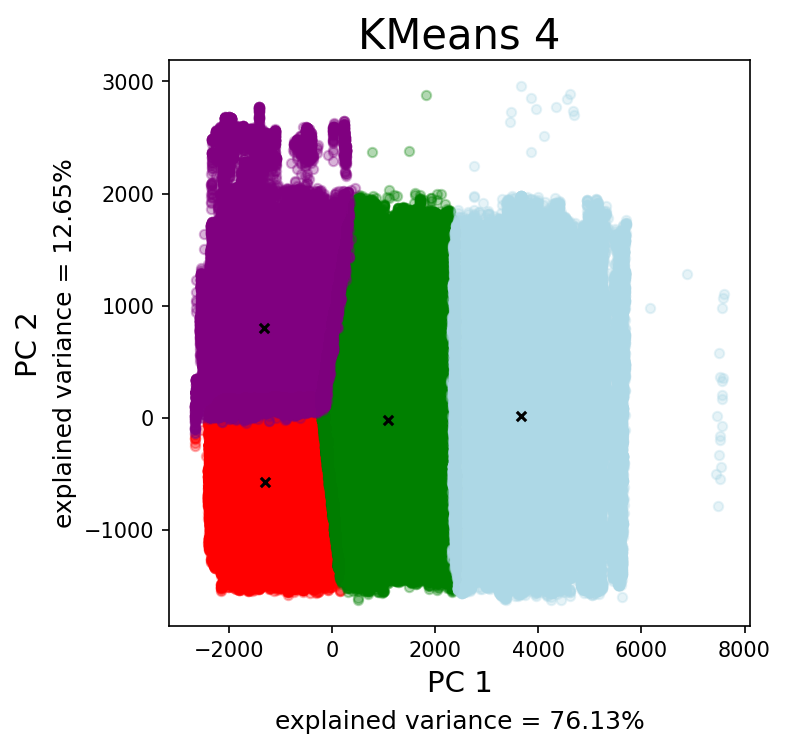

In [18]:
# Plot clusters and their centers
fig, ax = plt.subplots(figsize=(5,5), dpi=150)
ax.set_xlabel('PC 1', fontsize = 14)
ax.set_ylabel('PC 2\n', fontsize = 14)
ax.text(0.5, -0.18, f'explained variance = {round(pca.explained_variance_ratio_[0]*100,2)}%', size=12, ha="center", transform=ax.transAxes)
ax.text(-0.2, 0.5, f'explained variance = {round(pca.explained_variance_ratio_[1]*100,2)}%', size=12, va="center", transform=ax.transAxes, rotation='vertical')
ax.set_title('KMeans 4', fontsize = 20)
targets = pc.kmeans4.unique().tolist()
colors = ['red', 'green','purple','lightblue']
for t, color in zip(targets, colors):
    ax.scatter(pc[pc.kmeans4 == t].PC1, pc[pc.kmeans4 == t].PC2, c = color, s = 20, alpha=0.3)
ax.scatter([x for x,y in clusters], [y for x,y in clusters], marker="x", s=20, color='black');

# Exercici 2

Classifica els diferents vols utilitzant l'algorisme de clustering jeràrquic.

### Seaborn

With the clustermap method of seaborn we can clusterize and visualize very quickly the flights:

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


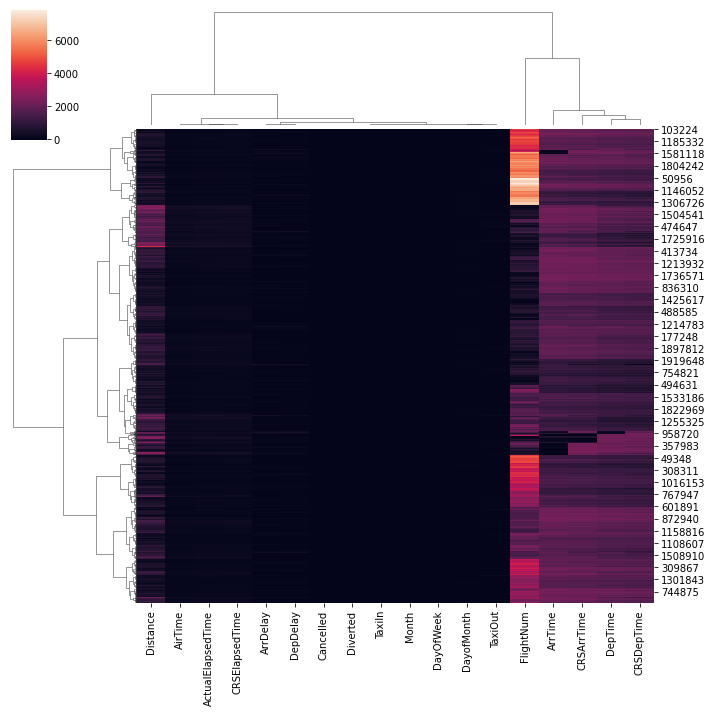

In [19]:
sns.clustermap(Xsmall, method='ward');

As we can see, the tallest branches indicate that the best classification is with 2 clusters.

### SciPy

With the linkage function of SciPy we can do the hierarchical clustering of the data and with the dendrogram we can plot it with more detail:

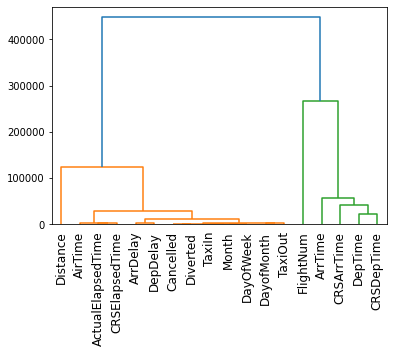

In [20]:
dendrogram(linkage(Xsmall.transpose(), method='ward'), leaf_rotation=90, labels=Xsmall.columns);

### Scikit-learn

With the AgglomerativeClustering method of scikit-learn be can do the hierarchical clustering very easy and get the labels of all flights:

In [21]:
clustering = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
predicted_labels = clustering.fit_predict(Xsmall)

In [22]:
pd.Series(predicted_labels).value_counts()

0    8398
1    1602
dtype: int64

# Exercici 3

Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.

With the silhouette score we can check the performance of the hierarchical clustering according to the number of clusters

In [23]:
silhouettes = []
for n_clusters in range(2, 11):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')  
    predicted_labels = clustering.fit_predict(Xsmall)
    silhouettes.append(silhouette_score(Xsmall, predicted_labels))

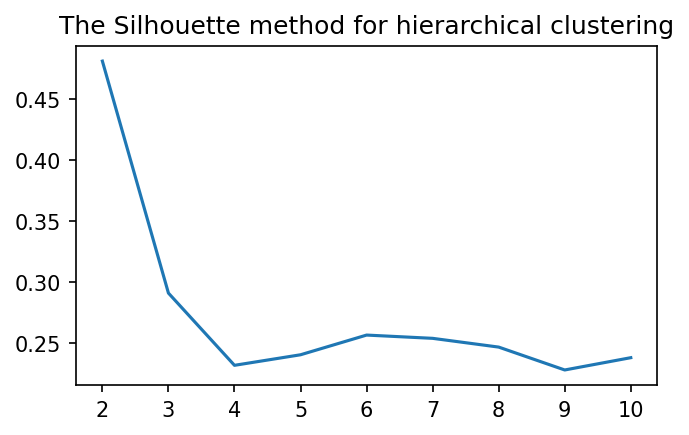

In [24]:
fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.set_title('The Silhouette method for hierarchical clustering')
plt.plot(range(2, 11), silhouettes);